#  <center> A Complete Guide to Boosting Methods </center>

This notebook **explains and compares** five of the most popular **boosting methods**: Adaboost, Gradient Boosting, XGBoost, LightGBM and CatBoost.

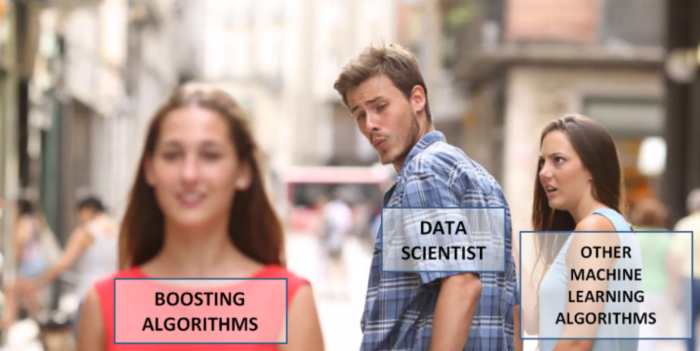

## ⭐ Summary ⭐

**Boosting** is a type of **ensemble methods** that builds decision trees **sequentially** so that each new tree **learns from the mistakes** made by the previous tree.

1. **`AdaBoost`**: trees are trained on **sampled training set** where **previsouly misclassified** examples are more likely to be sampled to train the next tree.


2. **`Gradient Boosting`**: **regressions trees** are trained to **predict the residuals** of the previous tree so that the residuals move towards zero iteratively.


3. **`XGBoost`**: a **fast and efficient** boosting algorithm that uses the **gradient boosting** framework, adopts an **unique tree building method**.


4. **`LightGBM`**: an improved **gradient boosting** algorithm that is **faster**, uses **less memory** and **more accurate** with the **DART** method.


5. **`CatBoost`**: a **gradient boosting** algorithm that is good at dealing with **categorical features** using a **permutation driven alternative**.

## Table of Contents

<a id="toc"></a>

- [1. Introduction: What is boosting?](#1)
        
        
- [2. Adaptive Boosting (AdaBoost)](#2)
    - 2.1 What is AdaBoost?
    - 2.2 How does AdaBoost work?
    - 2.3 Implementing AdaBoost
    
    
- [3. Gradient Boosting](#3)
    - 3.1 What is Gradient Boosting?
    - 3.2 How does Gradient Boosting work?
    - 3.3 Implementing Gradient Boosting


- [4. Extreme Gradiant Boosting (XGBoost)](#4)
    - 4.1 What is XGBoost?
    - 4.2 How does XGBoost work?
    - 4.3 Implementing XGBoost


- [5. Light Gradient Boosting Machine (LightGBM)](#5)
    - 5.1 What is LightGBM?
    - 5.2 Implementing LightGBM


- [6. Categorical Boosting (CatBoost)](#6)
    - 6.1 What is CatBoost?
    - 6.2 Implementing CatBoost

### ⭐ This notebook assumes that your are familiar with decision trees and the idea of ensemble learning.

If not, check out this notebook: [A Complete Guide to Decision Trees & Ensembles](https://www.kaggle.com/code/ryanluoli2/a-complete-guide-to-decision-trees-ensembles)

## Import Data

In this notebook, I will **demonstrate** how we can **implement these boosting algorithms** in predicting house prices using the data from this competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

(I have done some **preprocessing** to clean the data before we can apply the models.)

In [37]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import KFold, cross_val_score
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [7]:
#import the cleaned training and test data
X_train = pd.read_csv('../input/cleaned-train-x/cleaned_train_X.csv')
y_train = pd.read_csv('../input/cleaned-train-y/cleaned_train_y.csv')

In [8]:
#define the evaluation metric as 5-fold cross-validation root-mean-square-error
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=0).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

<a id="1"></a>

# <center>Introduction: What is Boosting?</center>

**`Ensemble methods`** are techniques that combine **multiple base learners** (e.g. trees) to produce improved results. In general, there are **3 categories**: 

1. **`Bagging`**: base learners are generated in **parallel** and combined to form a single strong learner that is **more stable** (i.e. reduce variance)


2. **`Boosting`**: base learners are generated **sequentially** such that **previous learners' mistakes** are learned to **improve predictability** (i.e. reduce bias)


3. **`Stacking`**: a **meta-learner** (as the final predictor) is trained **based on the predictions** of **heterogeneous and parallel** base learners


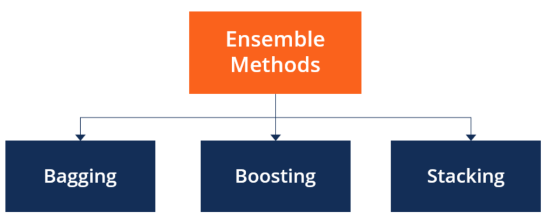

Image Source: https://corporatefinanceinstitute.com/resources/knowledge/other/ensemble-methods/

Generally speaking, an **ensemble method** work like this:

1. **sample** the training data **with replacement** to create a new training set
2. train a **shallow decision tree** on this new training set
3. **repeat** the above steps and **combine the results** of all the trees

A **boosting method** has a similar work flow but with a slight difference in the **sampling step**: instead of sampling examples with **equal probability** ($\frac{1}{m}$), the sampling probability (**weight**）of each example **updates** iteratively such that **"hard" examples** are more likely to be sampled to **train the next tree**.

The **"hard" examples** are the examples in the training set where the **previous tree** made a mistake (e.g. misclassified). By **increasing the probability** of sampling the "hard" examples, the **next tree** can put **more focus** making correct predictions on the "hard" examples. This process is called **boosting**.

<a id="2"></a>

# <center>Adaptive Boosting (AdaBoost)</center>

## What is AdaBoost?

You can think of **`AdaBoost`** as a **weighted linear combination** of trees.

For example, let's say we trained $T$ trees **sequentially** and each tree $h_{t}$ gives a prediction **$h_{t}(x)$** on an input data $x$. If we assign a distinct weight $\alpha_{t}$ to each tree, our **final predictor** is given as:

$$f(x) = \sum \limits _{t=1} ^{T} \alpha_{t} h_{t}(x)$$

where the weight $\alpha_{t}$ depends on the **training error** of each tree (larger weights for better performing trees).

The **base learners (i.e. trees)** used in an AdaBoost algorithm are usually **stumps** (trees with only a single split) which are weak enough to prevent **overfitting**. On the other hand, to aovid **underfitting** we need to make sure we use **enough amount** of these weak learners.

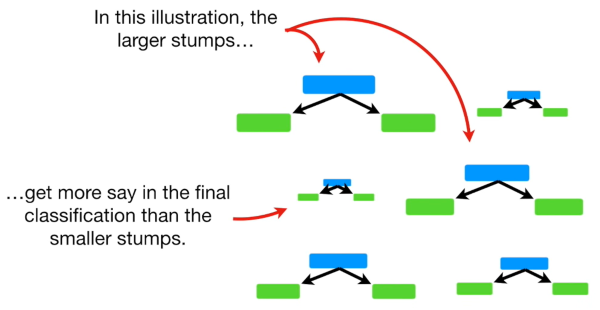

Image Source: https://www.youtube.com/watch?v=LsK-xG1cLYA

## How does AdaBoost work?

Let me walk you through the **`steps of the AdaBoost algorithm`**:

1. initialize the **sampling distribution** $D_{t}(i)$ to **uniform**, so that each examples in the training set will be sampled with **equal probabilities**


2. the following steps will be **repeated for $t=1,2,...,T$ iterations** to create **$T$ trees** in total


3. sample a **new training set** with the distribution $D_{t}(i)$ (Note: for $t=1$, we use the original training set)


4. train a **tree $h_{t}$** on the sampled data and compute the **weighted training error $e_{t}$**:

$$e_{t} = \sum \limits _{i=1} ^{m} D_{t}(i)I[h_{t}(x_{i}=y_{i}]$$

5. compute the **weight $\alpha_{t}$** for this tree:

$$\alpha_{t} = \frac{1}{2}log(\frac{1-e_{t}}{e_{t}})$$

6. update the **sampling distribution $D_{t}(i)$**:

$$D_{t}(i) = \frac{D_{t}(i)e^{-\alpha_{t}y_{i}h_{t}}}{z_{t}}$$ 

where $z_{t}$ is the **normalized constant** that froces the sum of the distribution $D_{t}(i)$ equal to 1.

7. start the next iteration with the **updated sampling distribution**

## Implementing AdaBoost

In [62]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(n_estimators = 500,
                        learning_rate = 0.05,
                        loss = 'exponential',
                        random_state = 0)

ada_score = rmsle_cv(ada)
print(f"AdaBoost 5-Fold Cross-Validation score: {round(ada_score.mean(),3)} ({round(ada_score.std(),3)})")

start = datetime.now()
ada.fit(X_train, y_train)
end = datetime.now()
print('AdaBoost Training time: ', (end-start).total_seconds(), ' seconds')

AdaBoost 5-Fold Cross-Validation score: 0.174 (0.006)
AdaBoost Training time:  8.043117  seconds


<a id="3"></a>

# <center>Gradient Boosting</center>

## What is Gradient Boosting?

Unlike **AdaBoost** where we have **weighted stumps**, all the trees in **`gradient boosting`** are **larger** (typically have 8~32 leaves) and **scaled equally**.

The **final predictor** of the gradient boosting is given as:

$$f(x) = \bar{y} + \alpha\sum \limits _{t=1} ^{T} h_{t}(x)$$

where $\bar{y}$ is the **mean y-value** of the training data and all the trees are scaled by the fixed **learning rate $\alpha$**.

You can think of this ensemble method as taking $T$ **samll steps** (each with size $\alpha$) towards the **right direction**. Evidence shows that this process can result in **better test scores** (i.e. lower variance).

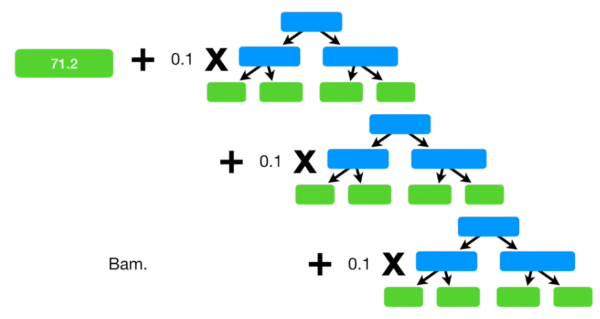

Image Source: https://www.youtube.com/watch?v=3CC4N4z3GJc

## How does Gradient Boosting work?

Instead of **sampling new training data** to build trees iteratively, gradient boosting always uses the **same training data** but **updates the target values** (y-values) iteratively based on the **predictions of the previous tree**. To be more specific, a new tree is trained to **predict the residuals $r$** of the previous tree where $r$ is the difference between the **predictions of the previous tree** and the **ground truth**.

Building new tree to **predict the residuals** is equivalent to **learning what was predicted wrong** by the previous trees. By do so, we are **iteratively improving** the predictability of our model.

Let me walk you through the **`steps of the Gradient Boosting algorithm`**:

1. start with an **initial guess**: the **mean y-value $\bar{y}$** of the training data 


2. compute the **pseudo residuals** for all examples using the prediction $\bar{y}$


3. the following steps will be **repeated for $t=1,2,...,T$ iterations** to create **$T$ trees** in total


4. build a tree $h_{t}$ using **all features** to **predict the residuals**


5. the **new predictions $F_{i}$** now is $F_{i} = \bar{y} + \alpha h_{1}(x) + \alpha h_{2}(x) ... + \alpha h_{t}(x)$


6. compute the **pseudo residuals $r_{i}$** using the new predictions:

$$r_{i} = - \frac{dL}{dF}$$

where $\frac{dL}{dF}$ is the **gradient** of the loss function.


7. build a **new tree** to predict the computed new residuals...

## Implementing Gradient Boosting

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

gbt = GradientBoostingRegressor(n_estimators = 500,
                                learning_rate = 0.05,
                                loss = 'squared_error',
                                max_depth = 4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                random_state = 0)

gbt_score = rmsle_cv(gbt)
print(f"Gradient Boosting 5-Fold Cross-Validation score: {round(gbt_score.mean(),3)} ({round(gbt_score.std(),3)})")

start = datetime.now()
gbt.fit(X_train, y_train)
end = datetime.now()
print('Gradient Boosting Training time: ', (end-start).total_seconds(), ' seconds')

Gradient Boosting 5-Fold Cross-Validation score: 0.123 (0.01)
Gradient Boosting Training time:  0.659332  seconds


<a id="4"></a>

# <center>Extreme Gradient Boosting (XGBoost)</center>

## What is XGBoost?

**`XGBoost`** is a **fast and efficient** boosting algorithm that uses the **gradient boosting** framework.

Let me list out the reasons why XGBoost is **more efficient** and **better performing** comparing to traditional gradient boosting:

1. Each tree is built with an **`approximate greedy algorithm`**: when looking for the **optimal split** at a node, XGBoost uses the **quantiles** of the data instead of the normally use thresholds.


2. XGBoost uses the **`sketch algorithm`** to find the **quantiles**: the data is divided into **blocks** so that **parallel computing** can be used to obtain **histograms** that give the quantiles.


3. XGBoost uses the **`weighted quantiles`**: **"hard" examples** are more likely to be split and therefore correctly classified.


4. XGBoost uses **`Sparsity-Aware Split Finding`** so that trees can still be built with **missing values** in the training data.


5. XGBoost stores the gradients in the **`cache memory`** so that it can make **rapid calculations** when building trees and computing the outputs.


6. XGBoost **`compresses`** the training data to avoid lot of time spending on accessing the **hard drive** in the cost of using only a little bit of time **decompressing** the data with CPU.


7. XGBoost also speeds up the tree building process by only using a **`random subset`** of data/features when the size of trainingd data is large.

## How does XGBoost work?

The steps of the XGBoost algorithm is similar to that of the gradient boosting algorithm, however, XGBoost **builds trees in a unique way**.

Instead of starting with a node, the trees of XGBoost **start with a leaf** containing all the **residuals** to be predicted:

1. the first step is to compute the **similarity score** of the leaf:

$$ S = \frac{(\sum r_{i})^2}{N_{r}+\lambda}$$

where $(\sum r_{i})^2$ is the **squared sum** of the residuals, $N_{r}$ is the number of residuals in the leaf and $\lambda$ is the **regularization** parameter used to prevent overfitting.


2. then, XGBoost finds the **optimal split** that **maximizes the grain**:

$$ gain = \sum S_{child} - S_{root}$$

where $\sum S_{child}$ is the **sum of similarity scores** of the child nodes after the split and $S_{root}$ is the similarity score of the root node.


3. the grown tree is **pruned** by setting a **minimum gain** for splitting to prevent overfitting

With such a unqiue tree building mechanism, XGBoost is able to **make better predictions** than traditional gradient boosting.

## Implementing XGBoost

Hyperparameter tuning can be found here: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [64]:
import xgboost as xgb

xgb = xgb.XGBRegressor(n_estimators = 500,
                       learning_rate = 0.05,
                       objective = 'reg:squarederror',
                       min_split_loss = 0.05,
                       max_depth = 4,
                       subsample = 0.8,
                       random_state = 0)

xgb_score = rmsle_cv(xgb)
print(f"XGBoost 5-Fold Cross-Validation score: {round(xgb_score.mean(),3)} ({round(xgb_score.std(),3)})")

start = datetime.now()
xgb.fit(X_train, y_train)
end = datetime.now()
print('XGBoost Training time: ', (end-start).total_seconds(), ' seconds')

XGBoost 5-Fold Cross-Validation score: 0.125 (0.008)
XGBoost Training time:  5.163623  seconds


<a id="5"></a>

# <center>Light Gradient Boosting Machine (LightGBM)</center>

## What is LightGBM?

**`LightGBM`** is a framework to implement **gradient boosting** with the following **advantages**:

1. **faster** training
2. **lower** memory usage
3. **better** accuracy
4. support **parallel**, **distributed** and **GPU** computing
5. capable of handling **large-scale** data
6. can deal with **categorical variables** directly to avoid potential disadvantages of **encoding**

Similar to XGBoost, LightGBM uses **histogram-based algorithms** to **speed up** the training process and reduce memory usage.

Unlike other boosting methods where trees are grown **level-wise** (width first), LightGBM grows trees **leaf-wise** (depth first): go for the **best leaf** with the maximum delta loss first. With a **fixed number of leaves**, leaf-wise building tends to achieve **lower loss** and hence **higher accuracy**. However, we still ne to set a **maximum depth** fot trees in LightGBM to prevent **overfitting**.

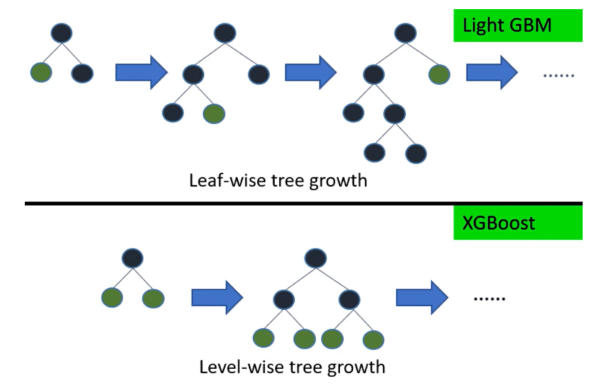

Image Source: https://lightgbm.readthedocs.io/en/latest/Features.html

## Implementing LightGBM

In [83]:
import lightgbm as lgb

lgb = lgb.LGBMRegressor(n_estimators = 500,
                        learning_rate = 0.05,
                        objective = 'regression',
                        num_leaves = 6,
                        random_state = 0)

lgb_score = rmsle_cv(lgb)
print(f"LightGBM 5-Fold Cross-Validation score: {round(lgb_score.mean(),3)} ({round(lgb_score.std(),3)})")

start = datetime.now()
lgb.fit(X_train, y_train)
end = datetime.now()
print('LightGBM Training time: ', (end-start).total_seconds(), ' seconds')

LightGBM 5-Fold Cross-Validation score: 0.126 (0.008)
LightGBM Training time:  0.445231  seconds


<a id="6"></a>

# <center>Categorical Boosting (CatBoost)</center>

## What is CatBoost?

**`CatBoost`** is an improved **gradient boosting** algorithm with its name coined from **"Category"** and "Boosting".

Unlike other boosting methods, CatBoost builds **symmetric (balanced) trees**. In a symmetric tree, **all nodes** in the same level are split using the **same condition**. Using a **balanced tree architecture** allows the CPU to perform computation **efficiently** (reduces prediction time) while preventing the algorithm from **overfiting**.

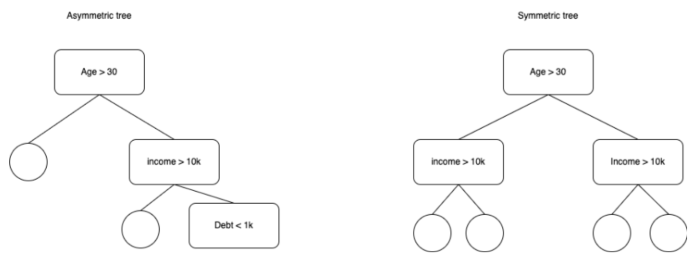

Image Source: https://neptune.ai/blog/when-to-choose-catboost-over-xgboost-or-lightgbm

Another **key feature** that makes CatBoost **robust** is that: it uses the concept of **ordered boosting** to avoid **overfitting**. CatBoost adopts a **permutation-driven** approach to train model on a **subset of data** while calcualting the **residuals** on another subset.

Finally, as its name suggests CatBoost is capable of dealing with **categorical variables**. Moreover, it can also deal with **text data** with inherent text preprocessing methods including **Bag-of-Words** and Naive-Bayes to transform text into **numerical features**.

## Implementing CatBoost

In [81]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(n_estimators = 500,
                        learning_rate = 0.05,
                        loss_function='RMSE',
                        verbose = 0,
                        random_state = 0)

cat_score = rmsle_cv(cat)
print(f"CatBoost 5-Fold Cross-Validation score: {round(cat_score.mean(),3)} ({round(cat_score.std(),3)})")

start = datetime.now()
cat.fit(X_train, y_train)
end = datetime.now()
print('CatBoost Training time: ', (end-start).total_seconds(), ' seconds')

CatBoost 5-Fold Cross-Validation score: 0.121 (0.011)
CatBoost Training time:  2.45637  seconds


### <center> Support me with an upvote if you find it useful! 👍 </center>